In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from dolfin import * 
import math
from IPython.display import clear_output
from time import sleep
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,8)

# Experiment setup

In [59]:
np.linalg.norm(u - task.u, 'fro')**2

11271107026.052942

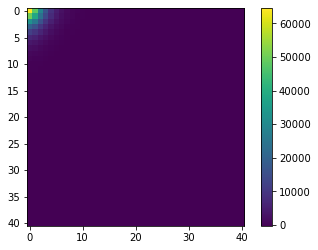

In [60]:
plt.imshow(task.u)
plt.colorbar()

In [2]:
from math import exp
import numpy as np
from functools import partial

def prior(x, sigma=1.):
    return np.exp(-0.5*np.log(x)**2/sigma**2).prod()

# F, d flatten
def posterior(x, F, d_obs, prior, sigma):
    return math.exp(-np.linalg.norm(F - d_obs)**2/sigma)*prior(x)
#     return math.exp(-np.linalg.norm(F - d_obs, 'fro')**2/sigma)


# F, F_m flatten    
def t_cond(F, F_m, sigma):
    return np.linalg.norm((F - F_m)/sigma, np.inf)

def normal_sampler(x, sigma=.1):
#     return np.clip(
#         np.random.multivariate_normal(x, np.diag([sigma]*len(x))), 
#         0., 1.)
    return np.random.multivariate_normal(x, np.diag([sigma]*len(x))) 

def metropolis_step(x, pi, q):
    new_x = q(x)
    alpha = min(1, pi(new_x)/(pi(x) + 1e-4))
#     print(new_x, x, pi(new_x), pi(x))
    if np.random.uniform() < alpha:
        return new_x, True, alpha
    else:
        return new_x, False, alpha
    
q = partial(normal_sampler, sigma=.1)

def alg_1(x, F, d_obs, chain_len, M_dim, eps, c, F_m, V_m, sigma):
    i = 0,
    while i <= chain_len:
        new_x, acceptance = metropolis_step(x, pi, q)
        i += 1
        F_new = forward(new_x)
        F_m_new = forward_m(new_x)
        if t_cond(F, F_m, sigma) >= eps:
            break
    beta = posterior(new_x, F_new, d_obs, prior, sigma)/posterior(x, F, d_obs, prior, sigma)
    beta *= posterior(x, F, d_obs, prior, sigma)/posterior(new_x, F_new, d_obs, prior, sigma)
    beta = min(1, beta)
    
    new_x, acceptance = new_x, True if np.random.uniform() < beta else new_x, False
    if len(V_m) < M_dim and t_cond(F_new, F_m_new, sigma) >= eps:
        V_m.append(solve(new_x))
    
    return new_x, acceptance, F_new, F_m_new, V_m

In [3]:
task = TaskSetup(2, 20, n_p=9, seed=102)
task.x, task.ri
# task.L[:600,1000:] = np.zeros((600, 600))

(array([3.94992707e-01, 1.10733882e+00, 1.80979274e+01, 3.27486600e+00,
        2.20638124e-01, 2.85266608e-01, 5.85953220e+00, 1.38463354e+00,
        6.70014755e-03]), array([[0.59768158, 0.6759869 ],
        [0.29928174, 0.73074027],
        [0.57873939, 0.80901767],
        [0.1672485 , 0.31214497],
        [0.35793155, 0.4917473 ],
        [0.49019824, 0.89440989],
        [0.18241053, 0.36116209],
        [0.81059146, 0.33344683],
        [0.5189505 , 0.26162022]]))

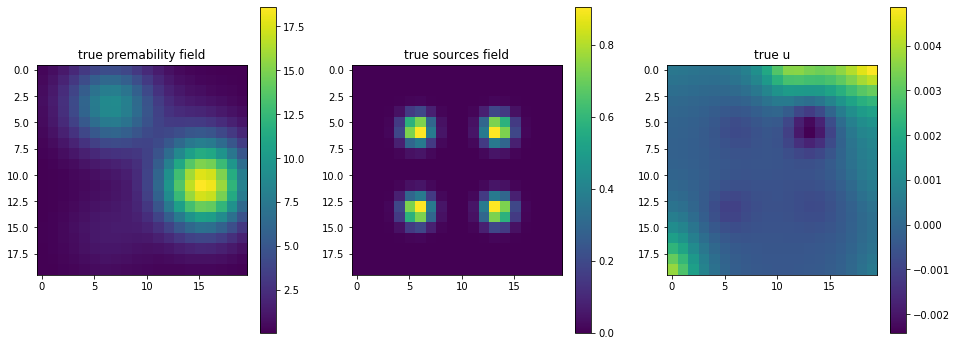

In [4]:
plt.rcParams['figure.figsize'] = (16,6)
plt.subplot(131); plt.imshow(task.K); plt.title('true premability field'); plt.colorbar()
plt.subplot(132); plt.imshow(task.Q); plt.title('true sources field'); plt.colorbar()
plt.subplot(133); plt.imshow(task.u); plt.title('true u'); plt.colorbar()
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 12))
# ax1.imshow(task.K); ax1.set_title('true premability field')
# ax2.imshow(task.Q); ax2.set_title('true sources field')
# ax3.imshow(task.u); ax3.set_title('true u')

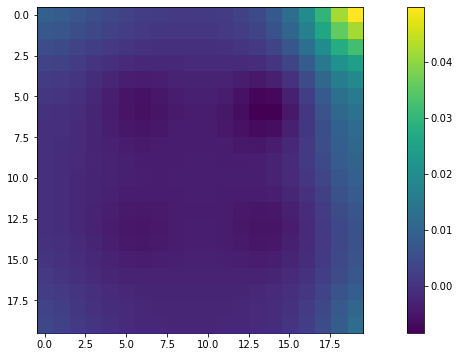

In [5]:
plt.imshow(task.evaluate(np.random.rand(9))[0])
plt.colorbar()

# alg1

In [191]:
sigma0 = 2
sigma_d = 1.
eps = 1e-3
x = np.random.lognormal(mean=.0, sigma=sigma0, size=task.n_p)
# x = np.clip(x, 0., 1.)
q = partial(normal_sampler, sigma=0.1)
N_maxiter = 10000
L = 50
c = 1e-1

snapshots = []
error_rows = []
n_steps = []
betas = []
time = 0
for i in range(N_maxiter):
    x_new = None
    stop = 0
    t = 0
    if len(snapshots) > 2:
        error_row = []
        y = x.copy()
        for j in range(L):
            u, _ = task.evaluate(y)
            u_m, dt = task.basis_projection_solution(y, snapshots, u, True)
            time += dt

            t = t_cond(u_m, u, sigma_d)
            error_row.append(t)
            if t > eps and j > 0 and len(n_steps) > 0 and np.mean(n_steps) > 1/c/eps:
                error_rows.append(error_row)
                n_steps.append(j)
                stop = j
                break
            pi = partial(posterior, F=u_m, d_obs=task.u, prior=prior, sigma=sigma_d)
            y_new, res, _ = metropolis_step(y, pi, q)
            if res:
                y = y_new
            if j == L-1:
                n_steps.append(j)
                stop = j
        x_new = y.copy()
    if x_new is None:
        x_new = q(x)
    u, dt = task.evaluate(x_new)
    time += dt
    pi = partial(posterior, F=u, d_obs=task.u, prior=prior, sigma=sigma_d)
    alpha = min(1, pi(x_new)/(pi(x) + 1e-4))
    if np.random.uniform() < alpha:
        betas.append(alpha)
        x = x_new
        if len(snapshots) > 2:
            u_m, dt = task.basis_projection_solution(x, snapshots, u, True)
            t = t_cond(u_m, task.u, sigma_d)
        else:
            t = 2*eps
        if  t > eps:
            snapshots.append(u)
    
#     field = np.zeros_like(task.K)
#     for i, x_ in enumerate(task.discr_row):
#         for j, y_ in enumerate(task.discr_row):
#             field[i, j] = pi(np.array([x_, y_]))
#             field[i, j] = prior(np.array([x_, y_]))

#     plt.subplot(121)
#     plt.imshow(u)
#     plt.colorbar()
#     plt.subplot(122)
#     plt.imshow(task.u - u)
#     plt.colorbar()
    
    mult = task.n_discr-1
#     if len(accepted) > 2:
#         accepted_ = np.array(accepted)
#         plt.plot(accepted_[:,1]*mult, accepted_[:,0]*mult, 'yo-')
#             plt.plot(accepted_[:,1], accepted_[:,0], 'y')
#     if len(rejected) > 2:
#         rejected_ = np.array(rejected)
#         plt.scatter(rejected_[:,1]*mult, rejected_[:,0]*mult, color='r', s=3)
#     clear_output()
#     plt.show()
    print(f'step {i}, basis size={len(snapshots)}')
    print(f'avg acceptance level = {np.mean(betas)}')
    print(f'time = {time}')
    print(f'stopped on {stop}th step, err={t}\n')
#     sleep(1)

  Calling FFC just-in-time (JIT) compiler, this may take some time.
step 0, basis size=0
avg acceptance level = nan
time = 0.20532200000161538
stopped on 0th step, err=0

  Calling FFC just-in-time (JIT) compiler, this may take some time.
step 1, basis size=0
avg acceptance level = nan
time = 0.3791590000018914
stopped on 0th step, err=0

  Calling FFC just-in-time (JIT) compiler, this may take some time.
step 2, basis size=0
avg acceptance level = nan
time = 0.5507440000019415
stopped on 0th step, err=0

  Calling FFC just-in-time (JIT) compiler, this may take some time.
step 3, basis size=0
avg acceptance level = nan
time = 0.7225360000011278
stopped on 0th step, err=0

  Calling FFC just-in-time (JIT) compiler, this may take some time.
step 4, basis size=0
avg acceptance level = nan
time = 0.893076000002111
stopped on 0th step, err=0

  Calling FFC just-in-time (JIT) compiler, this may take some time.
step 5, basis size=0
avg acceptance level = nan
time = 1.064886000001934
stopped o

/home/marina/anaconda3/envs/fenicsproject/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


step 59, basis size=2
avg acceptance level = 1.0
time = 11.152660000008837
stopped on 0th step, err=0.002

  Calling FFC just-in-time (JIT) compiler, this may take some time.
step 60, basis size=3
avg acceptance level = 1.0
time = 11.358377000009568
stopped on 0th step, err=0.002

  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compi

KeyboardInterrupt: 

In [192]:
x

array([ 12.31314695,  41.97507303,  -4.7628478 ,   5.42353849,
         9.83109396, -10.40937717, -14.55346019,  28.19918768,
         1.89468142])

# alg2

In [8]:
sigma0 = 2
sigma_d = 1.
eps = 1e-2
eps0 = sigma_d
x = np.random.lognormal(mean=.0, sigma=sigma0, size=task.n_p)
x = np.clip(x, 0., 1.)
q = partial(normal_sampler, sigma=0.1)
N_maxiter = 10000
L = 100
c = 1e-2
len_min = 5

full_counter = 0
snapshots = []
error_rows = []
n_steps = []
time = 0
for i in range(N_maxiter):
    x_new = None
    stop = 0
    t = 0
    if len(snapshots) > len_min:
        error_row = []
        y = x.copy()
        for j in range(L):
            u, _ = task.evaluate(y)
            u_m, dt = task.basis_projection_solution(y, snapshots, u)
            time += dt
            t = t_cond(u_m, u, sigma_d)
#             error_row.append(t)
            if t > eps and j > 0 and len(n_steps) > 0 and np.mean(n_steps) > 1/c/eps:
#                 error_rows.append(error_row)
                n_steps.append(j)
                stop = j
                break
            pi = partial(posterior, F=u_m, d_obs=task.u, prior=prior, sigma=sigma_d)
            y_new, res, _ = metropolis_step(y, pi, q)
            if res:
                y = y_new
            if j == L-1:
                n_steps.append(j)
                stop = j
        x_new = y.copy()
    
    if x_new is None:
        x_new = q(x)
    u, dt1 = task.evaluate(x_new)
    if len(snapshots) > len_min:
        u_m, dt2 = task.basis_projection_solution(y, snapshots, u)
        t_m = t_cond(task.u, u_m, sigma_d)
    if len(snapshots) <= len_min or t_m > eps0:
        time += dt1
        full_counter += 1
        pi = partial(posterior, F=u, d_obs=task.u, prior=prior, sigma=sigma_d)
        beta = min(1, pi(x_new)/(pi(x) + 1e-4))
        if np.random.rand() < beta:
            x = x_new
            snapshots.append(u)
    else:
        time += dt2
        pi_m = partial(posterior, F=u_m, d_obs=task.u, prior=prior, sigma=sigma_d)
        beta = min(1, pi(x_new)/(pi(x) + 1e-4))
        if np.random.rand() < beta:
            time += dt1
            full_counter += 1
            pi = partial(posterior, F=u, d_obs=task.u, prior=prior, sigma=sigma_d)
            beta = min(1, pi(x_new)/(pi(x) + 1e-4))
            if np.random.rand() < beta:
                x = x_new
                snapshots.append(u)
   
    print(f'step {i}, basis size={len(snapshots)}, full_model_evals={full_counter}')
    print(f'time = {time}')
    print(f'stopped on {stop}th step, err={t}')
#     sleep(1)

Calling FFC just-in-time (JIT) compiler, this may take some time.
step 0, basis size=1, full_model_evals=1
time = 0.17922199999999933
stopped on 0th step, err=0
Calling FFC just-in-time (JIT) compiler, this may take some time.
step 1, basis size=1, full_model_evals=2
time = 0.33536699999999975
stopped on 0th step, err=0
Calling FFC just-in-time (JIT) compiler, this may take some time.
step 2, basis size=1, full_model_evals=3
time = 0.4877900000000004
stopped on 0th step, err=0
Calling FFC just-in-time (JIT) compiler, this may take some time.
step 3, basis size=1, full_model_evals=4
time = 0.6414480000000005
stopped on 0th step, err=0
Calling FFC just-in-time (JIT) compiler, this may take some time.
step 4, basis size=2, full_model_evals=5
time = 0.8029510000000002
stopped on 0th step, err=0
Calling FFC just-in-time (JIT) compiler, this may take some time.
step 5, basis size=2, full_model_evals=6
time = 0.9567130000000006
stopped on 0th step, err=0
Calling FFC just-in-time (JIT) compile

/home/marina/anaconda3/envs/fenicsproject/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


step 12, basis size=6, full_model_evals=13
time = 2.0356650000000007
stopped on 0th step, err=0
Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/marina/UQ_project/utils.py:132: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeffs, _, _, _ = np.linalg.lstsq(U, u)


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FF

KeyboardInterrupt: 

Calling FFC just-in-time (JIT) compiler, this may take some time.


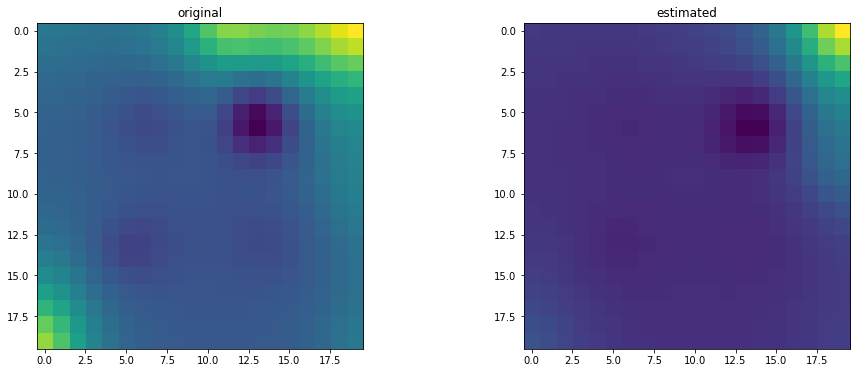

In [66]:
u, _ = task.evaluate(task.x + np.random.normal(0, 1.75, size=task.x.shape)) 
plt.subplot(121)
plt.imshow(task.u); plt.title('original')
plt.subplot(122); plt.title('estimated')
plt.imshow(u)

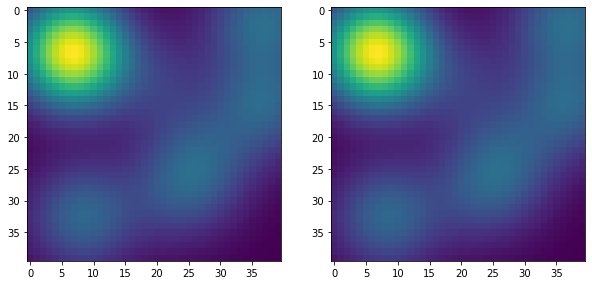

In [208]:
field = np.zeros_like(task.K)
task.rbfs[0].ufl_evaluate(np.array([.1, .2]), None, ())
for i, x_ in enumerate(task.discr_row):
    for j, y_ in enumerate(task.discr_row):
        val = 0
        for k, x in enumerate(task.x):
            val += x*task.rbfs[k].ufl_evaluate(np.array([x_, y_]), None, ())
        field[i, j] = val
        
plt.subplot(121)
plt.imshow(field)
plt.subplot(122)
plt.imshow(task.K)

1
Calling FFC just-in-time (JIT) compiler, this may take some time.
2
3
4
5
6


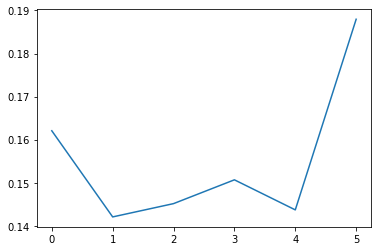

In [52]:
rez = []
x = np.random.rand(len(task.x))
for i in range(1, len(snapshots)):
    print(i)
    u_m = task.basis_projection_solution(x, snapshots[:i])
    rez.append(t_cond(u_m, task.u, sigma_d))
plt.plot(rez)
#     print(t_cond(u_m, task.u, sigma_d))
#     plt.imshow(u_m - task.u)
#     plt.colorbar()

In [224]:
u, rez = task.evaluate(x)

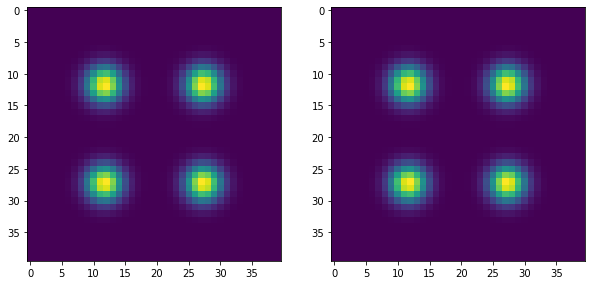

In [231]:
q = [Expression(
            f"exp(-0.5 * (pow((x[0] - 0.3), 2) + pow((x[1] - 0.3), 2)) / pow({task.q_sigma}, 2))", degree=2
        ),  Expression(
            f"exp(-0.5 * (pow((x[0] - 0.3), 2) + pow((x[1] - 0.7), 2)) / pow({task.q_sigma}, 2))", degree=2
        ),  Expression(
            f"exp(-0.5 * (pow((x[0] - 0.7), 2) + pow((x[1] - 0.3), 2)) / pow({task.q_sigma}, 2))", degree=2
        ), Expression(
            f"exp(-0.5 * (pow((x[0] - 0.7), 2) + pow((x[1] - 0.7), 2)) / pow({task.q_sigma}, 2))", degree=2
        )]

field = np.zeros_like(task.K)
for i, x_ in enumerate(task.discr_row):
    for j, y_ in enumerate(task.discr_row):
        field[i, j] = sum([elem.ufl_evaluate(np.array([x_, y_]), None, ()) for elem in q])
        
plt.subplot(121)
plt.imshow(field)
plt.subplot(122)
plt.imshow(task.Q)

In [230]:
type(q)

ufl.algebra.Sum

In [223]:
min(rez)

278.9203297926982

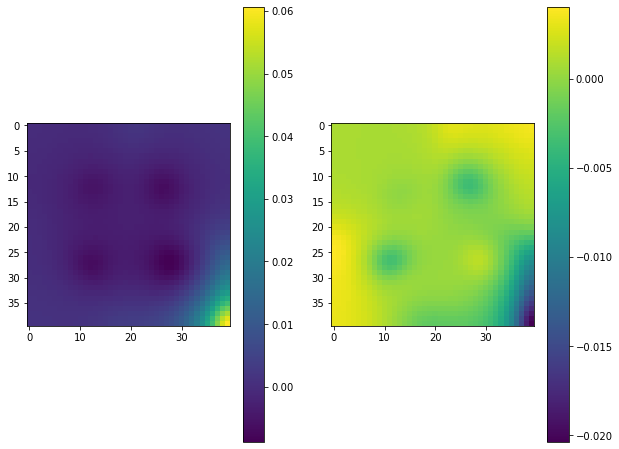

8 0


KeyboardInterrupt: 

In [119]:
sigma0 = 2
x = np.random.lognormal(mean=.0, sigma=sigma0, size=task.n_p)
x = np.clip(x, 0., 1.)
q = partial(normal_sampler, sigma=0.1)

accepted = [x]
rejected = []
for _ in range(100):
    u = task.evaluate(x)
    pi = partial(posterior, F=u, d_obs=task.u, prior=prior, sigma=30000)
    
    x_new, res = metropolis_step(x, pi, q)
    
    if res:
        accepted.append(x_new)
        x = x_new
    else:
        rejected.append(x_new)
        
#     field = np.zeros_like(task.K)
#     for i, x_ in enumerate(task.discr_row):
#         for j, y_ in enumerate(task.discr_row):
#             field[i, j] = pi(np.array([x_, y_]))
#             field[i, j] = prior(np.array([x_, y_]))
    plt.subplot(121)
    plt.imshow(u)
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(task.u - u)
    plt.colorbar()
    
    mult = task.n_discr-1
    if len(accepted) > 2:
        accepted_ = np.array(accepted)
#         plt.plot(accepted_[:,1]*mult, accepted_[:,0]*mult, 'yo-')
#             plt.plot(accepted_[:,1], accepted_[:,0], 'y')
    if len(rejected) > 2:
        rejected_ = np.array(rejected)
#         plt.scatter(rejected_[:,1]*mult, rejected_[:,0]*mult, color='r', s=3)
    clear_output()
    plt.show()
    print(len(accepted), len(rejected))
    sleep(1)

In [98]:
snapshots[0].shape

(40, 40)

In [65]:
task = TaskSetup(2, 40, n_p=9)
u = task.evaluate(task.x)

Calling FFC just-in-time (JIT) compiler, this may take some time.


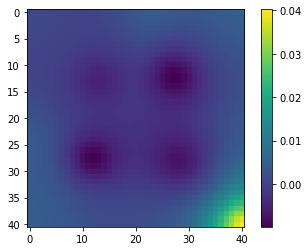

In [67]:
plt.imshow(u)
plt.colorbar()

In [412]:
task.eval_u_x(np.random.rand(len(task.x)), np.random.rand(*task.K.shape)).shape

(40, 40)

In [419]:
from scipy.optimize import minimize

def opt(u):
#     print('here ', opt.i)
#     opt.i += 1
    u = u.reshape(*task.K.shape)
    res = np.linalg.norm(task.eval_u_x(task.x, u))
    return res

# opt.i = 0

In [422]:
res = minimize(opt, np.random.rand(np.prod(task.K.shape)), options={'maxiter': 1000, 'disp': True})
res

         Current function value: 0.056354
         Iterations: 1000
         Function evaluations: 1603602
         Gradient evaluations: 1001


      fun: 0.05635396505082187
 hess_inv: array([[115.95377677,  43.66586996,   2.86655047, ...,  88.56076755,
          2.6200385 , -94.36878596],
       [ 43.66586996,  18.39183735,   2.42420345, ...,  34.07384659,
         -4.48770447, -46.06575686],
       [  2.86655047,   2.42420345,   4.00326161, ...,   3.98062018,
        -11.35998517, -25.80623969],
       ...,
       [ 88.56076755,  34.07384659,   3.98062018, ..., 115.21758275,
         52.72571053, -57.03174485],
       [  2.6200385 ,  -4.48770447, -11.35998517, ...,  52.72571053,
        137.39214959, 138.68101782],
       [-94.36878596, -46.06575686, -25.80623969, ..., -57.03174485,
        138.68101782, 298.44288139]])
      jac: array([ 0.00044638,  0.00071003, -0.00016379, ...,  0.00025414,
        0.00044609, -0.0003708 ])
  message: 'Maximum number of iterations has been exceeded.'
     nfev: 1603602
      nit: 1000
     njev: 1001
   status: 1
  success: False
        x: array([11.79778428,  3.76959217, -1.72338452, .

In [ ]:
def normal_sampler(x, n_discr, sigma=.1):
    ret = np.random.normal(x, np.diag([sigma]*len(x)))
    return np.array(ret)

In [646]:
def normal_sampler(x, sigma=.1):
    return np.random.multivariate_normal(x, np.diag([sigma]*len(x)))

def metropolis_step(x, pi, q):
    new_x = q(x)
    alpha = min(1, pi(new_ind)/pi(old_ind))
    if np.random.rand() < alpha:
        return new_x, True
    else:
        return new_x, False
    
q = partial(normal_sampler, sigma=.1)

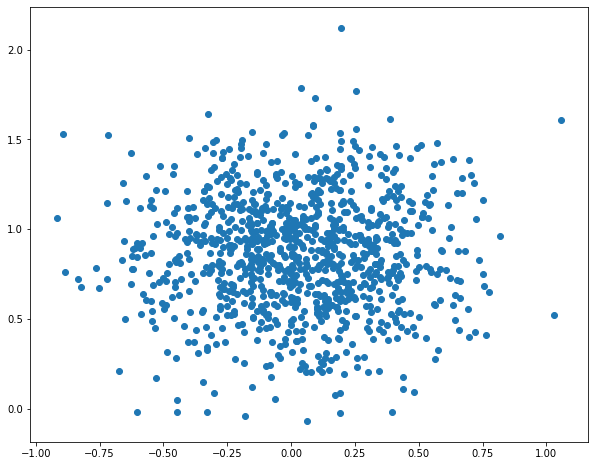

In [647]:
x = np.random.rand(2)
points = []
for _ in range(1000):
    points.append(normal_sampler(x))
points = np.array(points)
plt.scatter(points[:,0], points[:,1])

# Basis orthogonalization

In [277]:
n_vec = 3
n_dim = 5
X = list(np.random.rand(n_vec, n_dim))
q = orthonormal(X) 
assert np.allclose(np.linalg.norm(q, axis=1), np.ones(n_vec))
assert np.allclose(np.diag(q @ q.T), np.ones(n_vec))
# print(np.linalg.norm(q, axis=1), np.diag(q @ q.T))

# Metropolis–Hastings algorithm

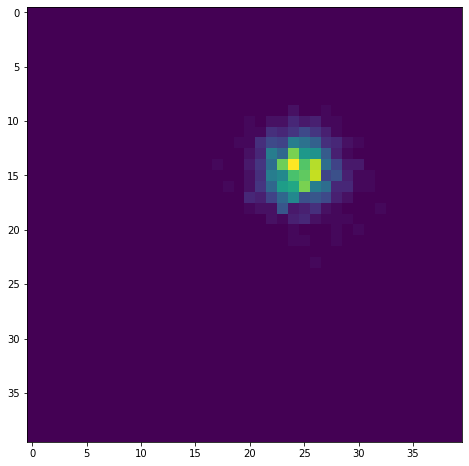

In [385]:
from scipy.stats import norm
from functools import partial

def normal_sampler(x, n_discr, sigma=.1):
    ret = []
    for ind in x:
        new_ind = norm.ppf(np.random.random(1), loc=ind, scale=sigma*n_discr).astype(int)   
        ret.append(np.clip(new_ind[0], 0, n_discr-1))
    return np.array(ret)
    
if task.n_dim == 2:
    X = np.zeros_like(task.K)
    x = np.array([15, 25])
    f = partial(normal_sampler, n_discr=task.n_discr, sigma=0.05)

    for _ in range(1000):
        x_new = f(x)
        ind1, ind2 = x_new
        X[ind1, ind2] += 1

    plt.imshow(X)

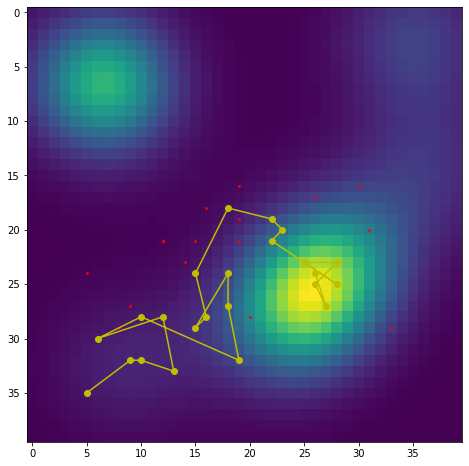

23 17


KeyboardInterrupt: 

In [399]:
from IPython.display import clear_output
from time import sleep

def metropolis_step(x, pi, q):
    """
    x: previous x (expected to be array of indexes)
    pi: pi(r), estimated distribution
    q: q(), sampling function, assumed to be symmetric
    
    returns: new_x (array of indexes), bool value (True if accepted)
    """
    new_x = q(x)
    old_ind = tuple(((k) for k in x))
    new_ind = tuple(((k) for k in new_x))
    alpha = min(1, pi[new_ind]/pi[old_ind])
#     print(alpha)
    if np.random.rand() < alpha:
        return new_x, True
    else:
        return new_x, False

if task.n_dim == 2:
    pi = task.K**2 
    x = np.array([35, 5])
    accepted = [x]
    rejected = []
    for _ in range(100):
        f = partial(normal_sampler, n_discr=task.n_discr, sigma=0.1)
        x_new, res = metropolis_step(x, pi, f)
#         x_new, res = f(x), True
        if res:
            accepted.append(x_new)
            x = x_new
        else:
            rejected.append(x_new)
            
        plt.imshow(pi)
        if len(accepted) > 2:
            accepted_ = np.array(accepted)
            
            plt.plot(accepted_[:,1], accepted_[:,0], 'yo-')
#             plt.plot(accepted_[:,1], accepted_[:,0], 'y')
        if len(rejected) > 2:
            rejected_ = np.array(rejected)
            plt.scatter(rejected_[:,1], rejected_[:,0], color='r', s=3)
        clear_output()
        plt.show()
        print(len(accepted), len(rejected))
        sleep(1)

In [402]:
np.gradient(np.random.rand(3, 3, 3))[0].shape

(3, 3, 3)

# dummy $u_0$

In [81]:
task = TaskSetup(2, 10, 9)
task.L[:20,80:] = np.zeros((20, 20))

In [90]:
G = task.G
L = task.L
x = np.random.rand(task.n_p)
k = task.eval_perm_field(x).T.flatten()
K = np.diag(k)
q = task.Q.T.flatten()

B1, B2 = boundary_matrices(task.n_discr)
k_d = double_vec(k)
K_d = np.diag(k_d)
B1_ = B1 @ K_d @ G

In [91]:
B1.shape, K_d.shape, G.shape

((36, 200), (200, 200), (200, 100))

In [92]:
np.diag(k_d).shape

(200, 200)

In [95]:
u_true = task.evaluate(x)
A @ u_true.T.flatten() + q

array([0.31061333, 0.31023365, 0.3105221 , 0.30892911, 0.30721457,
       0.3066359 , 0.30664914, 0.30666172, 0.30666039, 0.30663284,
       0.30818517, 0.30638661, 0.30627652, 0.30650085, 0.30653236,
       0.30657461, 0.30718072, 0.3068114 , 0.30661327, 0.30659228,
       0.30832832, 0.30642317, 0.3962475 , 0.54736064, 0.3110775 ,
       0.31114051, 0.54568838, 0.39560282, 0.30680216, 0.30658996,
       0.30768224, 0.30683821, 0.54790615, 0.95280365, 0.31857889,
       0.31871809, 0.94865627, 0.54575674, 0.30714431, 0.30662863,
       0.3074166 , 0.30739518, 0.31064966, 0.31766803, 0.30629875,
       0.30674174, 0.31866918, 0.31104989, 0.30658001, 0.30676976,
       0.30732777, 0.30843438, 0.30456611, 0.3120134 , 0.30641746,
       0.30657637, 0.31830645, 0.31077275, 0.30657037, 0.30739332,
       0.29238664, 0.29887511, 0.57284623, 0.97247635, 0.31406768,
       0.31814286, 0.95299908, 0.54808496, 0.30713467, 0.30780128,
       0.26079825, 0.29478228, 0.41470899, 0.56526152, 0.30890

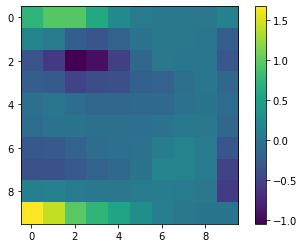

In [94]:
A = (np.dot(G.T @ G, k).T + K @ L)
u = np.linalg.solve(A, -q)
# A = np.vstack([(np.dot(G.T @ G, k) + K @ L), B1_, B2])
# length = B1.shape[0] + 1
# b = np.hstack([q, np.zeros(length)])
# u, res, _, _ = np.linalg.lstsq(A, -b)


grad_u = (G @ u).reshape(100, 2)
grad_k = (G @ k).reshape(100, 2)
term1 = np.sum(grad_u*grad_k, axis=1)

term2 = K @ (L @ u)

plt.imshow((term1 + term2 + q).T.reshape(10, 10))
plt.colorbar()

In [16]:
B1, B2 = boundary_matrices(10)

In [17]:
B1.shapeB1.shape

AttributeError: 'numpy.ndarray' object has no attribute 'shapeB1'

In [18]:
(B @ G @ u).shape
B @ G @ u

NameError: name 'B' is not defined

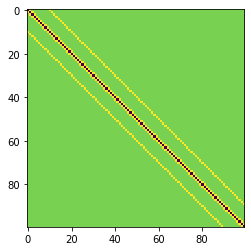

In [19]:
N = task.n_discr
L[:20,80:] = np.zeros((20, 20))
plt.imshow(L)

In [20]:
L.shape

(100, 100)

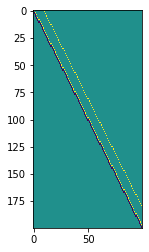

In [21]:
plt.imshow(task.G)

In [278]:
try:
    [1, 2, 3][4]
except IndexError:
    pass